In [167]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn import metrics

In [2]:
def mostrarHistograma(imagen):
    histograma = cv2.calcHist([imagen], [0], None, [256], [0,256])
    plt.figure(figsize = (10,7))
    plt.plot(np.arange(len(histograma[:,0])), histograma[:,0])

In [13]:
def im_to_col(imagen, m, n):
    filas, columnas = imagen.shape
    a = m//2
    b = n//2
    imagen2 = np.zeros((m*n, filas*columnas))
    imagen = cv2.copyMakeBorder(imagen, a, a, b, b, cv2.BORDER_REPLICATE)
    aux = 0
    for i in range(a, filas+a):
        for j in range(b, columnas+b):
            imagen2[:, aux] = imagen[i-a:i+a+1, j-b:j+b+1].flatten()
            aux += 1
    return imagen2

In [171]:
def modificarImagen(imagen,n):
    
    imagen_modificada = cv2.resize(imagen, (n, n), interpolation=cv2.INTER_AREA)
            
    return imagen_modificada

In [172]:
def preprocesamiento(imagen):
    #Ampliacion del rango dinamico
    nueva = np.float32(imagen)
    r1 = np.min(nueva)
    r2 = np.max(nueva)
    if (r2-r1) < 240:
        nueva = 255*(nueva - r1) / (r2 - r1)

    #Ecualizacion del histograma
    num_pixels = nueva.size
    hp = cv2.calcHist([nueva], [0], None, [256], [0,256])/num_pixels
    hp = hp.cumsum()
    nueva = hp[np.uint8(nueva)] * 255
    
    #Suavizado
    H = np.ones((5,5))/25
    m,n = H.shape
    imagen_aux = im_to_col(nueva,m,n)
    filas, columnas = nueva.shape
    H = H.reshape(1,-1)
    nueva = H.dot(imagen_aux).reshape(-1,columnas)
    nueva = np.uint8(nueva)

    #Modificar tamaño imagen
    nueva = modificarImagen(nueva,256)
    
    return nueva

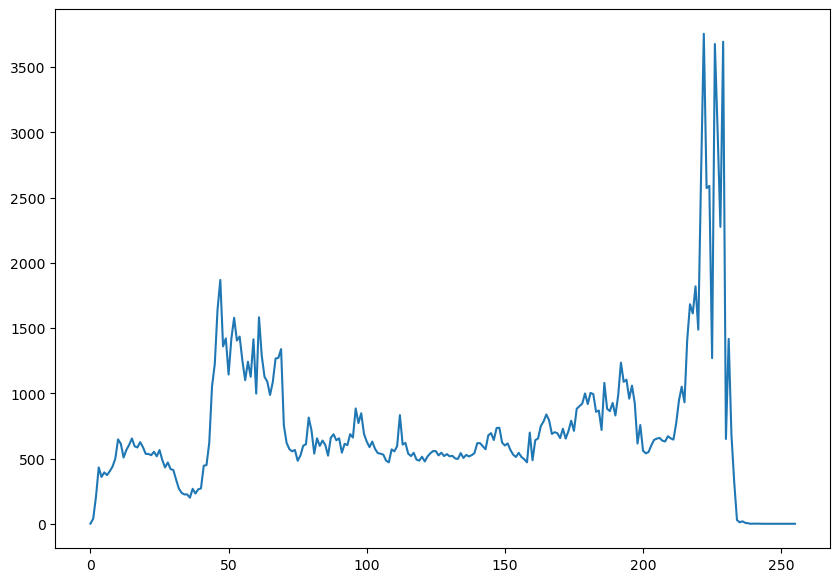

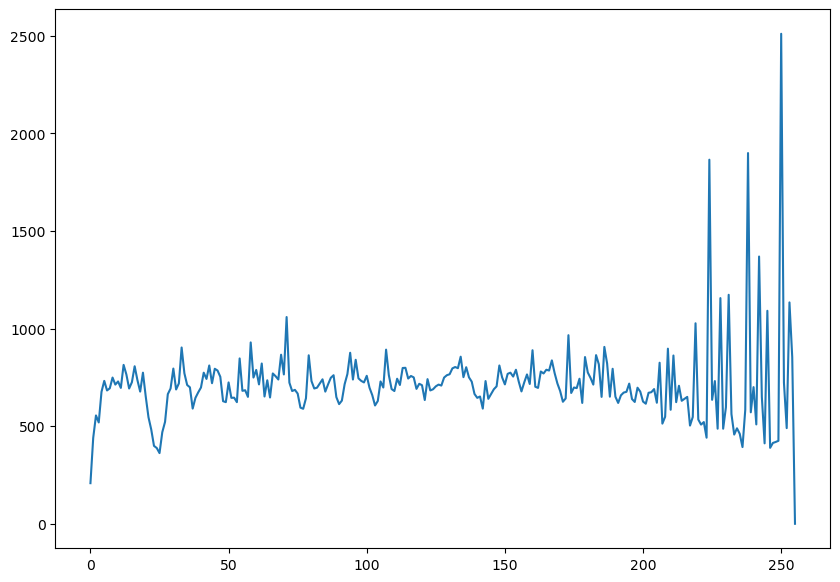

In [138]:
imagen = cv2.imread('dataset/cat_dog_100/train/cat/cat.0.jpg',0)
mostrarHistograma(imagen)
imagen2 = preprocesamiento(imagen)
mostrarHistograma(imagen2)
cv2.imshow('original', imagen)
cv2.imshow('ampliacion', imagen2)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [43]:
def gradiente(imagen):

    imagen_x = cv2.Sobel(imagen, cv2.CV_32F,1,0,ksize = 1)
    imagen_y = cv2.Sobel(imagen, cv2.CV_32F,0,1,ksize = 1)

    E = np.sqrt(np.power(imagen_x, 2) + np.power(imagen_y, 2))
    Phi = np.arctan2(imagen_y, imagen_x)
    Phi = np.rad2deg(Phi)

    return np.uint8(E), np.uint8(Phi)

In [145]:
def histogramasXceldas(num, E, phi):
    filas, columnas = imagen.shape
    histogramas = []
    for i in range(0, filas, num):
        for j in range(0, filas, num):
            celdaMag = E[i:i+num,j:j+num].flatten()
            celdaOri = phi[i:i+num,j:j+num].flatten()
            h = np.zeros(9)
            indices = celdaOri//(360//9)
            
            h = np.bincount(indices, weights=celdaMag, minlength=9)
            
            h = h/(np.sqrt(np.sum(h ** 2))+1e-6)
            histogramas.append(h)
    return histogramas
            

In [99]:
def extraccionCaracteristicas(imagen, num):
    imagen = np.float32(imagen)
    E, phi = gradiente(imagen)
    caracteristicas = np.concatenate(histogramasXceldas(num, E, phi))
    return caracteristicas
    

In [164]:
def entrenamiento():
    X_train = []
    y_train = []
    for i in range(100):
        imagen = cv2.imread('dataset/cat_dog_100/train/cat/cat.'+str(i)+'.jpg',0)
        imagen = preprocesamiento(imagen)
        caracteristicas = extraccionCaracteristicas(imagen, 16)
        X_train.append(caracteristicas)
        y_train.append(0)
        
    for i in range(100):
        imagen = cv2.imread('dataset/cat_dog_100/train/dog/dog.'+str(10000+i)+'.jpg',0)
        imagen = preprocesamiento(imagen)
        caracteristicas = extraccionCaracteristicas(imagen, 16)
        X_train.append(caracteristicas)
        y_train.append(1)

    # clf = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 5, 5), random_state=1)
    X_train = np.array(X_train)
    y_train = np.array(y_train)

    modelo = make_pipeline(StandardScaler(), SVC(kernel='rbf', C=1.0, random_state=42))
    modelo.fit(X_train, y_train)

    return modelo

In [165]:
def evaluacion(modelo):
    X_test = []
    y_test = []
    imagenes = []
    for i in range(20):
        imagen = cv2.imread('dataset/cat_dog_100/test/cat/cat.'+str(10000+i)+'.jpg',0)
        imagenes.append(imagen)
        imagen = preprocesamiento(imagen)
        caracteristicas = extraccionCaracteristicas(imagen, 16)
        X_test.append(caracteristicas)
        y_test.append(0)
        
        
    for i in range(20):
        imagen = cv2.imread('dataset/cat_dog_100/test/dog/dog.'+str(10000+i)+'.jpg',0)
        imagen = preprocesamiento(imagen)
        imagenes.append(imagen)
        caracteristicas = extraccionCaracteristicas(imagen, 16)
        X_test.append(caracteristicas)
        y_test.append(1)
        
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    y_pred = modelo.predict(X_test)

    acc = np.round(metrics.accuracy_score(y_pred,y_test)*100,2)

    return acc, imagenes, y_pred

    

In [173]:
modelo = entrenamiento()
acc, imagenes, predicciones = evaluacion(modelo)
print('El porcentaje de acierto del modelo es del {}%'.format(acc))

for i,imagen in enumerate(imagenes):
    if predicciones[i] == 0:
        label = 'Clasificada como gato'
    else:
        label = 'Clasificada como perro'
        
    cv2.imshow(label, imagen)
    cv2.waitKey(0)

cv2.destroyAllWindows()

El porcentaje de acierto del modelo es del 90.0%
